# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Streaming_Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final project: Structured Streaming** </center>
<div style="text-align: center;">
    <br>
    <strong>Estudiante:</strong> Juan Pablo Quintero <br>
    <strong>Fecha:</strong> 23 de Noviembre de 2025 <br>
    <strong>Profesor:</strong> Pablo Camarrilo Ramirez 
</div>

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Proyecto : Structured Streaming") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:4.0.0") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.apache.spark#spark-sql-kafka-0-10_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7d1bc83f-86ac-47fa-b3eb-ed84010311a0;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.13;4.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.13;4.0.0 in central
	found org.apache.kafka#kafka-clients;3.9.0 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.7 in central
	found org.slf4j#slf4j-api;2.0.16 in central
	found org.apache.hadoop#hadoop-client-runtime;3.4.1 in central
	found org.apache.hadoop#hadoop-client-api;3.4.1 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.scala-lang.modules#scala-parallel-collections_2.13;1.2.0

# Contexto (Objetivo)


### <center>En este proyecto de streaming processing vamos a usar el data set de accidentes en estados unidos, vamos a usar kafka y vamos a crear un script en python para poder hacer este proyecto, lo que queremos lograr es limpiar datos y quitar valores nulos de las columnas </center>

# Consumer

In [2]:
#Dataset and Stream creation
from pyspark.sql.functions import from_json, col, year, month, when
from pyspark.sql.types import *
from PabloQuintero.spark_utils import SparkUtils
schema = SparkUtils.generate_schema([
    ("ID", "StringType"),
    ("Source", "StringType"),
    ("Severity", "IntegerType"),
    ("Start_Time", "TimestampType"),
    ("End_Time", "TimestampType"),
    ("Start_Lat", "DoubleType"),
    ("Start_Lng", "DoubleType"),
    ("End_Lat", "DoubleType"),
    ("End_Lng", "DoubleType"),
    ("Distance(mi)", "DoubleType"),
    ("Description", "StringType"),
    ("Street", "StringType"),
    ("City", "StringType"),
    ("County", "StringType"),
    ("State", "StringType"),
    ("Zipcode", "StringType"),
    ("Country", "StringType"),
    ("Timezone", "StringType"),
    ("Airport_Code", "StringType"),
    ("Weather_Timestamp", "TimestampType"),
    ("Temperature(F)", "DoubleType"),
    ("Wind_Chill(F)", "DoubleType"),
    ("Humidity(%)", "DoubleType"),
    ("Pressure(in)", "DoubleType"),
    ("Visibility(mi)", "DoubleType"),
    ("Wind_Direction", "StringType"),
    ("Wind_Speed(mph)", "DoubleType"),
    ("Precipitation(in)", "DoubleType"),
    ("Weather_Condition", "StringType"),
    ("Amenity", "BooleanType"),
    ("Bump", "BooleanType"),
    ("Crossing", "BooleanType"),
    ("Give_Way", "BooleanType"),
    ("Junction", "BooleanType"),
    ("No_Exit", "BooleanType"),
    ("Railway", "BooleanType"),
    ("Roundabout", "BooleanType"),
    ("Station", "BooleanType"),
    ("Stop", "BooleanType"),
    ("Traffic_Calming", "BooleanType"),
    ("Traffic_Signal", "BooleanType"),
    ("Turning_Loop", "BooleanType"),
    ("Sunrise_Sunset", "StringType"),
    ("Civil_Twilight", "StringType"),
    ("Nautical_Twilight", "StringType"),
    ("Astronomical_Twilight", "StringType")
])




# Stream creation

In [3]:
kafka_df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:9093") \
    .option("subscribe", "us_accidents_streams") \
    .option("startingOffsets", "latest") \
    .load()

json_df = kafka_df.selectExpr("CAST(value AS STRING) as json_string")

raw_df = json_df.select(from_json(col("json_string"), schema).alias("data")).select("data.*")

kafka_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



# Transformations

In [4]:
# TRANSFORMACIONES Y LIMPIEZA
cleaned_df = raw_df \
    .withColumnRenamed("Distance(mi)", "Distance_mi") \
    .withColumnRenamed("Temperature(F)", "Temperature_F") \
    .withColumnRenamed("Wind_Chill(F)", "Wind_Chill_F") \
    .withColumnRenamed("Humidity(%)", "Humidity_Percent") \
    .withColumnRenamed("Pressure(in)", "Pressure_in") \
    .withColumnRenamed("Visibility(mi)", "Visibility_mi") \
    .withColumnRenamed("Wind_Speed(mph)", "Wind_Speed_mph") \
    .withColumnRenamed("Precipitation(in)", "Precipitation_in")

final_df = cleaned_df \
    .withColumn("Year", year(col("Start_Time"))) \
    .withColumn("Month", month(col("Start_Time"))) \
    .withColumn("Is_Severe_Accident", when(col("Severity") >= 3, "Yes").otherwise("No")) \
    .filter(col("ID").isNotNull()) 

final_df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance_mi: double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature_F: double (nullable = true)
 |-- Wind_Chill_F: double (nullable = true)
 |-- Humidity_Percent: double (nullable = true)
 |-- Pressure_in: double (nullable = true)
 |-- 

# Persistence Data

In [8]:
output_path = "./accidents_parquet_data/"
checkpoint_path = "./accidents_checkpoint/"

query = final_df.writeStream \
    .format("parquet") \
    .outputMode("append") \
    .option("path", output_path) \
    .option("checkpointLocation", checkpoint_path) \
    .partitionBy("Year", "Month") \
    .trigger(processingTime="10 seconds") \
    .start()

print("El consumidor está escuchando y guardando datos")

El consumidor está escuchando y guardando datos


25/11/24 02:29:37 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/11/24 02:57:50 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 10000} milliseconds, but spent 10896 milliseconds
                                                                                

# Evidencia de los datos pasados

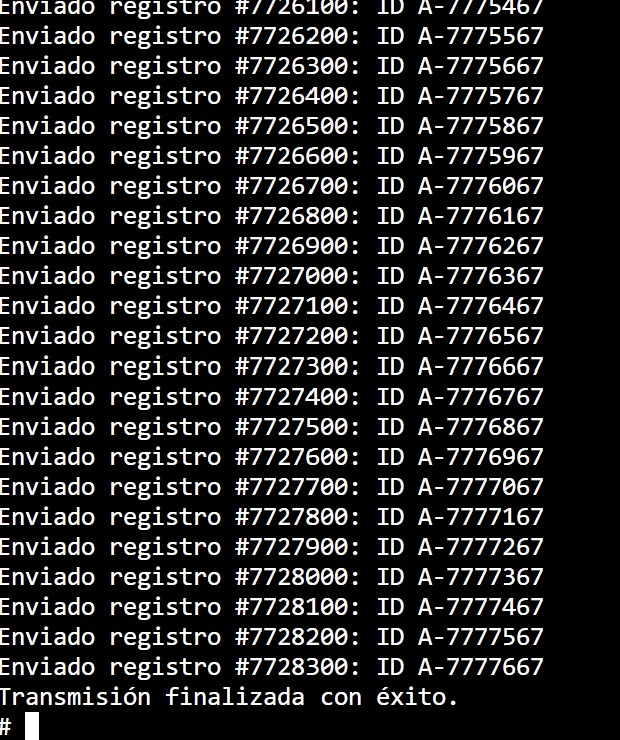
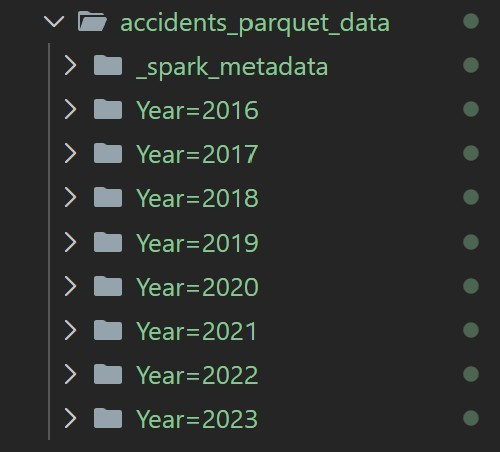
### <center> se inicia el producer.py que esta conectado al kafka, el kafka ya tiene que estar creado, es a su vez guarda en la carpetas creadas cona nterioridad, archivos .paquet, estos son muy buenos para mover data sets pesados y con mucho volumen como este de car accident, y se guardan por mes y año. </center>

# Imagenes PowerBI